# BDI Tutorial - Basic Verification Workflow

In this notebook we present a fairly generic verification workflow that should be adaptable to other scenarios. The scenario for this example is a verification of Latin *translator* style, based on (Latin) function word frequencies. We will examine two files from an unknown translator (called 'Myst') and try to determine:
- Are the works plausibly translated by the same translator?
- Are either of the works translated by one of the known translators (for whom we have many examples)

This summarizes work done for DH Benelux 2023, from the same team who wrote [this paper](https://journals.uco.es/mediterranea/article/view/16723) (about a slightly different problem but using similar methods).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

import logging

logging.basicConfig(level="INFO")
logger = logging.getLogger("ruzicka")

from ruzicka.BDIVerifier import BDIVerifier

# file in the local directory, not a package
from preproc import preprocess_and_slice_text_files

import mpl_fontkit as fk

fk.install("Roboto Condensed")

Font name: `Roboto Condensed`


## Preprocessing

We have supplied a basic preprocessing script that expects plain textfiles. It is no frills - it will read every file in the given directory, lowercase and remove punctuation, and split each file into 1000 word chunks (to increase the number of comparison samples). Chunking the texts this way also gives us a better feel for the internal variation within a text.

> NOTE: We can't supply the actual text files for public download because of licenses, so we have also supplied the processed data, later

In [2]:
raw_df = preprocess_and_slice_text_files("../data/txt")
raw_df

INFO:root:'BurCom.txt' was processed and split into 24 samples
INFO:root:'AristPha.txt' was processed and split into 20 samples
INFO:root:'BurInt.txt' was processed and split into 64 samples
INFO:root:'AnonMetaph.txt' was processed and split into 61 samples
INFO:root:'BurEthN.txt' was processed and split into 4 samples
INFO:root:'BarMor.txt' was processed and split into 20 samples
INFO:root:'AristMet.txt' was processed and split into 6 samples
INFO:root:'BarMirab.txt' was processed and split into 7 samples
INFO:root:'WilMet.txt' was processed and split into 30 samples
INFO:root:'MystAdv.txt' was processed and split into 10 samples
INFO:root:'JamPhys.txt' was processed and split into 53 samples
INFO:root:'WilInPar.txt' was processed and split into 161 samples
INFO:root:'BarMun.txt' was processed and split into 5 samples
INFO:root:'WilTet.txt' was processed and split into 33 samples
INFO:root:'BarRhet.txt' was processed and split into 14 samples
INFO:root:'BarSig.txt' was processed and s

,tag,chunk
0,BurCom_0,quoniam quidem ex calido et frigido et sicco e...
1,BurCom_1,sermo non quod nunquam fit in uno eodemque cor...
2,BurCom_2,horis anni invenire quartam coniugationem comp...
3,BurCom_3,quod necesse est in ea putrefieri omnia incipi...
4,BurCom_4,de ipsis per capitula quantum ad presentia uti...
...,...,...
1206,BurFid_48,ostendat quod secundum veritatem est homo cum ...
1207,BurFid_49,causative dicere ut hoc tibi soli peccavi et p...
1208,BurFid_50,condemnavit peccatum in carne ut iustitia legi...
1209,BurFid_51,uxorem suam et concepit et genuit quare propte...


## Extract metadata from filename

Depending how the source files were named, you might want to create new dataframe columns...

In [3]:
def splitfunc(x: pd.Series) -> list[str]:
    txt, chunk = x.tag.split("_")
    rest = re.findall(r"[A-Z][a-z]*", txt)
    return [chunk, rest[0], "".join(rest[1:])]


tmp = raw_df.apply(
    splitfunc,
    axis=1,
    result_type="expand",
)
raw_df.insert(0, "chunk_num", tmp[0])
raw_df.insert(0, "translator", tmp[1])
raw_df.insert(0, "work", tmp[2])
raw_df

,work,translator,chunk_num,tag,chunk
0,Com,Bur,0,BurCom_0,quoniam quidem ex calido et frigido et sicco e...
1,Com,Bur,1,BurCom_1,sermo non quod nunquam fit in uno eodemque cor...
2,Com,Bur,2,BurCom_2,horis anni invenire quartam coniugationem comp...
3,Com,Bur,3,BurCom_3,quod necesse est in ea putrefieri omnia incipi...
4,Com,Bur,4,BurCom_4,de ipsis per capitula quantum ad presentia uti...
...,...,...,...,...,...
1206,Fid,Bur,48,BurFid_48,ostendat quod secundum veritatem est homo cum ...
1207,Fid,Bur,49,BurFid_49,causative dicere ut hoc tibi soli peccavi et p...
1208,Fid,Bur,50,BurFid_50,condemnavit peccatum in carne ut iustitia legi...
1209,Fid,Bur,51,BurFid_51,uxorem suam et concepit et genuit quare propte...


## Factorizing

The BDI code will need numeric labels. The simplest way to get this is using pandas built-in `factorize()` method

In [4]:
labels, label_uniques = raw_df.translator.factorize()
raw_df.insert(1, "translator_label", labels)
raw_df

,work,translator_label,translator,chunk_num,tag,chunk
0,Com,0,Bur,0,BurCom_0,quoniam quidem ex calido et frigido et sicco e...
1,Com,0,Bur,1,BurCom_1,sermo non quod nunquam fit in uno eodemque cor...
2,Com,0,Bur,2,BurCom_2,horis anni invenire quartam coniugationem comp...
3,Com,0,Bur,3,BurCom_3,quod necesse est in ea putrefieri omnia incipi...
4,Com,0,Bur,4,BurCom_4,de ipsis per capitula quantum ad presentia uti...
...,...,...,...,...,...,...
1206,Fid,0,Bur,48,BurFid_48,ostendat quod secundum veritatem est homo cum ...
1207,Fid,0,Bur,49,BurFid_49,causative dicere ut hoc tibi soli peccavi et p...
1208,Fid,0,Bur,50,BurFid_50,condemnavit peccatum in carne ut iustitia legi...
1209,Fid,0,Bur,51,BurFid_51,uxorem suam et concepit et genuit quare propte...


## Preprocessing Summary

You should have:
- Your verification category factorized (often the author, here the translator)
- The chunked text to vectorize in a column

Other information that might be useful depends on the specific scenario. Here we will use the work name.

## Vectorizing

For this problem, we worked with Latin function words, which have multiple spelling variants. In this case, our vectorization process is a little complex. For many texts it would be enough to vectorize using n-gram frequencies. In any case, we will eventually need **a single X dataframe with one numeric vector per sample**. Here it will be (eventually) z-scaled function word frequencies.

In [5]:
# list of lists, so we can keep info about spelling variants in individual arrays

stops = []

with open("../data/functionwords.txt", "r") as file:
    for line in file:
        words = [x for x in line.lower().split() if x != "/"]
        stops.append(list(set(words)))

print(stops[:3])

[['atqvi', 'atqui'], ['aut', 'avt'], ['avtem', 'autem']]


In [6]:
flat_stops = [item for sublist in stops for item in sublist]

In [7]:
# doing this without IDF really just makes it a normalised CountVectorizer. Not
# using IDF because the frequency 'boosting' is really a form a fitting, and we
# want to save that for the classification algorithms.

# L1 vs L2 normalisation is a methodological question. Since we are only counting a subset of the
# vocabulary, L1 seems to make less sense?
v = TfidfVectorizer(use_idf=False, analyzer="word", decode_error="replace", norm="l2")
# only count our stopwords
v.fit(flat_stops)


def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        ary = sorted(list(set(ary)))
        # each array is a list of spelling variants. sum the counts for all the
        # variants of this stopword that appear in the df, using the first array
        # entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

> NOTE: This X dataframe is NOT YET SCALED. Because we will use z-scaling, it is methodologically more sound to fit the scaler on the comparison set, and then scale the problems using the fitted scaler (so no frequency information about the problems leaks into the z-scores)

In [8]:
X = pd.concat([vectorize(x) for x in raw_df.chunk], axis=0).reset_index(drop=True)
X

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,0.0,0.024275,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,0.0,0.000000,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,0.0,0.023002,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,0.0,0.014118,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1207,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1208,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,0.0,0.000000,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1209,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,0.0,0.000000,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


Since we can't distribute the raw texts, we have exported the processed corpus, as above so people can follow the rest of the example.

In [2]:
corpus = pd.read_csv("../data/corpus.csv", index_col=0)
corpus

,work,translator_label,translator,chunk_num,tag,atqui,aut,autem,certe,ceu,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Com,0,Bur,0,BurCom_0,0.0,0.097100,0.534050,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Com,0,Bur,1,BurCom_1,0.0,0.200297,0.578636,0.0,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Com,0,Bur,2,BurCom_2,0.0,0.230022,0.575055,0.0,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Com,0,Bur,3,BurCom_3,0.0,0.243044,0.710436,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Com,0,Bur,4,BurCom_4,0.0,0.649435,0.409426,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,Fid,0,Bur,48,BurFid_48,0.0,0.024500,0.538996,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1207,Fid,0,Bur,49,BurFid_49,0.0,0.000000,0.421459,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1208,Fid,0,Bur,50,BurFid_50,0.0,0.000000,0.738485,0.0,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1209,Fid,0,Bur,51,BurFid_51,0.0,0.000000,0.666795,0.0,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [10]:
raw_df = corpus.iloc[:, :5]
X = corpus.iloc[:, 5:]

## Split Data

Here we will use the terms *problems* and *comparison set*. Elsewhere the comparison set might be called the 'training set', but the so-called training for the `BDIVerifier` is really minimal, it just stores the comparison data in memory.

In our scenario, we will use one work, named 'Adv' by the mystery translator (broken into 10 chunks) and the other work ('Pyrr') (broken into 11 chunks) will go into the comparison set. You need *at least one* comparison text by the target to perform verification. Apart from that, the 'imposters' part of Bootstrap Distance Imposters are a set of other texts which should be roughly compatible by genre (not critical) and produced by authors who might be theoretically plausible alternatives (writing in the same language, around the same time, etc.)

In [11]:
problems = raw_df[raw_df.work == "Adv"].reset_index(drop=True).copy()
problems_X = X[raw_df.work == "Adv"].reset_index(drop=True).copy()
problems

,work,translator_label,translator,chunk_num,tag
0,Adv,5,Myst,0,MystAdv_0
1,Adv,5,Myst,1,MystAdv_1
2,Adv,5,Myst,2,MystAdv_2
3,Adv,5,Myst,3,MystAdv_3
4,Adv,5,Myst,4,MystAdv_4
5,Adv,5,Myst,5,MystAdv_5
6,Adv,5,Myst,6,MystAdv_6
7,Adv,5,Myst,7,MystAdv_7
8,Adv,5,Myst,8,MystAdv_8
9,Adv,5,Myst,9,MystAdv_9


In [12]:
rest = raw_df[raw_df.work != "Adv"].reset_index(drop=True).copy()
rest_X = X[raw_df.work != "Adv"].reset_index(drop=True).copy()
rest

,work,translator_label,translator,chunk_num,tag
0,Com,0,Bur,0,BurCom_0
1,Com,0,Bur,1,BurCom_1
2,Com,0,Bur,2,BurCom_2
3,Com,0,Bur,3,BurCom_3
4,Com,0,Bur,4,BurCom_4
...,...,...,...,...,...
1196,Fid,0,Bur,48,BurFid_48
1197,Fid,0,Bur,49,BurFid_49
1198,Fid,0,Bur,50,BurFid_50
1199,Fid,0,Bur,51,BurFid_51


## Scaling

Now that we have split, we can fit the scaler on just the comparison set, and scale both the problems and the comparison data...

In [13]:
ss = StandardScaler(with_mean=False).fit(rest_X)

In [14]:
rest_scaled_X = ss.transform(rest_X)
problems_scaled_X = ss.transform(problems_X)

## Verification

Now it is time to do the verification! Here we will perform 1000 bootstrap iterations per sample, using the Ružička (minmax) metric, as promoted in the following paper: Kestemont, M., Stover, J., Koppel, M., Karsdorp, K. & Daelemans, W., ‘Authenticating the writings of Julius Caesar’. In: Expert Systems with Applications 63 (2016): pp. 86–96.

> BDI is a modification / update based on the `Order2Verifier` code from the paper above

In [39]:
rng = np.random.default_rng(42)

In [40]:
# Create the verifier object

bdi_mm = BDIVerifier(
    metric="minmax", nb_bootstrap_iter=1000, rnd_prop=0.35, random_state=rng
)

In [41]:
bdi_mm.fit(rest_scaled_X, rest.translator_label)

11/14/2024 11:21:42 [ruzicka:INFO] Fitting on 1201 documents...


## Verifying against every label

The key method for BDI is `predict_proba()`. It takes a set of problems (from the X array), and a set of labels to test each problem against (candidate label). Here we demonstrate by testing the problem text against every candidate label. Full documentation is available with `help(BDIVerifier.predict_proba)`

In [42]:
# label_uniques is a pandas Index of strings. The numeric labels index into these strings (i.e., they are
# in the same order)
for label in label_uniques.values:
    print(f"Testing against {label}")
    # get_loc gives us the numeric label for a string
    code = label_uniques.get_loc(label)
    # make target labels the same length as the number of problem rows
    print(
        f"Bootstrap Match Strength (one per chunk, 0–1.0): {bdi_mm.predict_proba(problems_scaled_X, [code] * problems_scaled_X.shape[0])}"
    )

11/14/2024 11:21:42 [ruzicka:INFO] Predicting on 10 documents


Testing against Bur


11/14/2024 11:21:44 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.383 0.606 0.432 0.364 0.382 0.486 0.648 0.564 0.497 0.175]
Testing against Arist


11/14/2024 11:21:45 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.136 0.086 0.021 0.2   0.086 0.076 0.328 0.392 0.14  0.333]
Testing against Anon


11/14/2024 11:21:45 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.287 0.53  0.527 0.442 0.299 0.554 0.444 0.459 0.552 0.179]
Testing against Bar


11/14/2024 11:21:46 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.451 0.463 0.612 0.474 0.499 0.508 0.656 0.675 0.641 0.335]
Testing against Wil


11/14/2024 11:21:49 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.96  0.979 0.975 0.977 0.976 0.988 0.935 0.811 0.97  0.962]
Testing against Myst


11/14/2024 11:21:49 [ruzicka:INFO] Predicting on 10 documents


Bootstrap Match Strength (one per chunk, 0–1.0): [0.436 0.618 0.309 0.829 0.551 0.612 0.564 0.962 0.715 0.645]
Testing against Jam
Bootstrap Match Strength (one per chunk, 0–1.0): [0.829 0.583 0.731 0.507 0.745 0.661 0.755 0.587 0.683 0.543]


## Interpretation

The 'match strength' reported is the bootstrap percentile of a metric distance of 0. If the candidate label is *closer* to the bootstrap sample, the distance will be positive, so this is essentially the 'confidence' that the candidate label is the best match. Empirically, confidence values over 0.89 have resulted in very high precision (very few false positives—see the paper). Values below this threshold are *not* reliable negative indicators.

In this case, we see a very strong match to the translator 'Wil' (William of Moerbeke), and also a mostly inconclusive match to the candidate 'Myst'. From this we conclude:
- This text was probably translated by 'Wil'
- It seems unlikely that the two 'Myst' texts were translated by the same person (but we cannot rule it out)

## Chunked Visualisation

One of the strengths of the BDI approach is that it foregrounds the uncertainty in our determinations. While the problem work is *mostly* a very good match for Moerbeke, we see significant internal variation in style, which might be interesting to investigate. Here we just demonstrate how to visualize the full distribution of bootstrap distances.

At each run for `predict_proba()`, the `_dist_arrays` property is also set, and contains the full bootstrap results (1000 distances per chunk, in this case)

In [43]:
# re-run the verification against 'Wil', to populate the _dist_arrays property
bdi_mm.predict_proba(
    problems_scaled_X, [label_uniques.get_loc("Wil")] * problems_scaled_X.shape[0]
)

11/14/2024 11:21:50 [ruzicka:INFO] Predicting on 10 documents


array([0.957, 0.977, 0.983, 0.979, 0.973, 0.972, 0.918, 0.844, 0.975,
       0.944])

In [44]:
adv_vs_wil = pd.DataFrame(dict(zip(problems.tag, bdi_mm._dist_arrays)))
adv_vs_wil

,MystAdv_0,MystAdv_1,MystAdv_2,MystAdv_3,MystAdv_4,MystAdv_5,MystAdv_6,MystAdv_7,MystAdv_8,MystAdv_9
0,0.373258,0.207470,0.297562,0.515677,0.189593,0.251056,0.365955,0.476793,0.046376,0.430859
1,0.508945,0.313482,0.009726,0.462671,0.222868,0.279429,0.239608,0.047420,0.154884,0.449830
2,0.323439,0.003054,0.176942,0.248971,0.048205,0.444074,0.237556,0.416950,0.325584,0.095047
3,0.256461,0.558439,0.333128,0.405757,0.045562,0.555803,0.143079,0.261227,0.507550,0.242404
4,0.396333,0.283641,0.021014,0.169165,0.187561,0.618120,0.250970,0.182334,0.047216,0.566218
...,...,...,...,...,...,...,...,...,...,...
995,0.308800,0.309764,0.098204,0.347586,0.172415,0.398659,0.001828,0.280810,0.287549,0.448102
996,0.498781,0.170736,0.250247,0.351567,0.257897,0.125067,0.056573,0.288503,0.162797,0.388947
997,-0.019845,0.489938,0.274352,0.431005,0.122474,0.425097,0.451223,0.347759,0.071090,0.296099
998,0.321651,0.202286,0.068416,0.378196,0.457324,0.080435,0.302638,0.264750,0.276980,0.419335


## Visualization

Here we use a quick seaborn KDE plot to visualize. To interpret these plots:
- If a distribution is credibly *positive* it indicates that the candidate is the best match
- If a distribution is *centered around zero* then it is entirely possible that the true producer is not in the candidate set
- If a distribution is credibly *negative* it indicates that one (or more) of the imposter candidates is consistently a better match

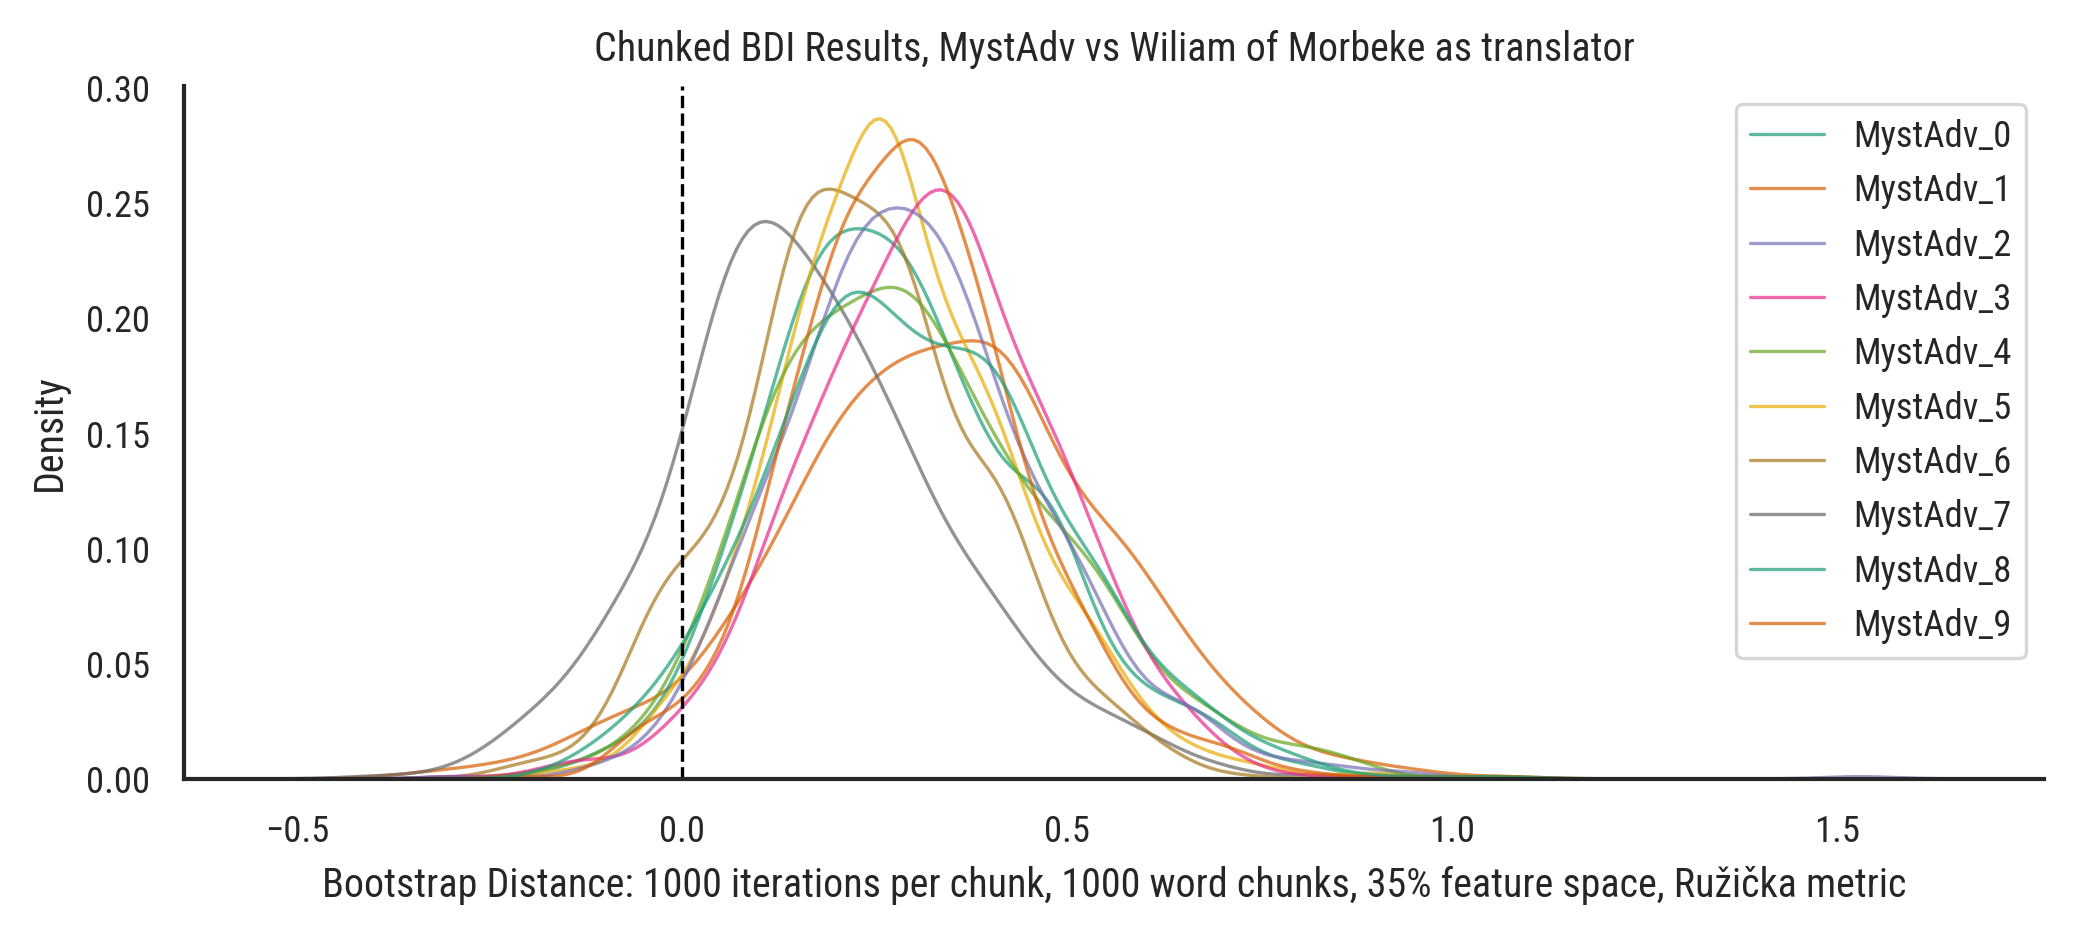

In [45]:
sns.set_theme(
    context="paper",
    font="Roboto Condensed",
    style="white",
    rc={"figure.figsize": (8, 3), "figure.dpi": 300},
)

ax = sns.kdeplot(adv_vs_wil, linewidth=0.8, alpha=0.7, palette="Dark2")
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.set(
    xlabel="Bootstrap Distance: 1000 iterations per chunk, 1000 word chunks, 35% feature space, Ružička metric",
    ylabel="Density",
    title="Chunked BDI Results, MystAdv vs Wiliam of Morbeke as translator",
)
sns.despine()
plt.show()

In [46]:
# re-run the verification against 'Myst'
bdi_mm.predict_proba(
    problems_scaled_X, [label_uniques.get_loc("Myst")] * problems_scaled_X.shape[0]
)

11/14/2024 11:21:54 [ruzicka:INFO] Predicting on 10 documents


array([0.416, 0.604, 0.322, 0.821, 0.58 , 0.65 , 0.54 , 0.956, 0.704,
       0.613])

In [47]:
adv_vs_myst = pd.DataFrame(dict(zip(problems.tag, bdi_mm._dist_arrays)))

## Alternative Candidate

The distributions here are:
- mostly centered around zero
- have much greater spread, indicating more uncertainty

The most reasonable interpretation is that the two translations by 'Myst' are not by the same person. However, in hypothesis testing / frequentist terms, $H_0$ here would be 'the candidate was not produced by the same person as the problem' and $H_1$ is 'the two texts are produced by the same person'. As always, failing to reject the null hypothesis *is not conclusive evidence that $H_0$ is the case*.

> NOTE: The match strength results from BDI are not well balanced (they favour precision, i.e., few false positive matches) so we *do not recommend* interpreting them as probabilities, and we deliberately avoid framing the (inverse) match-strength as a "bootstrap p-value".

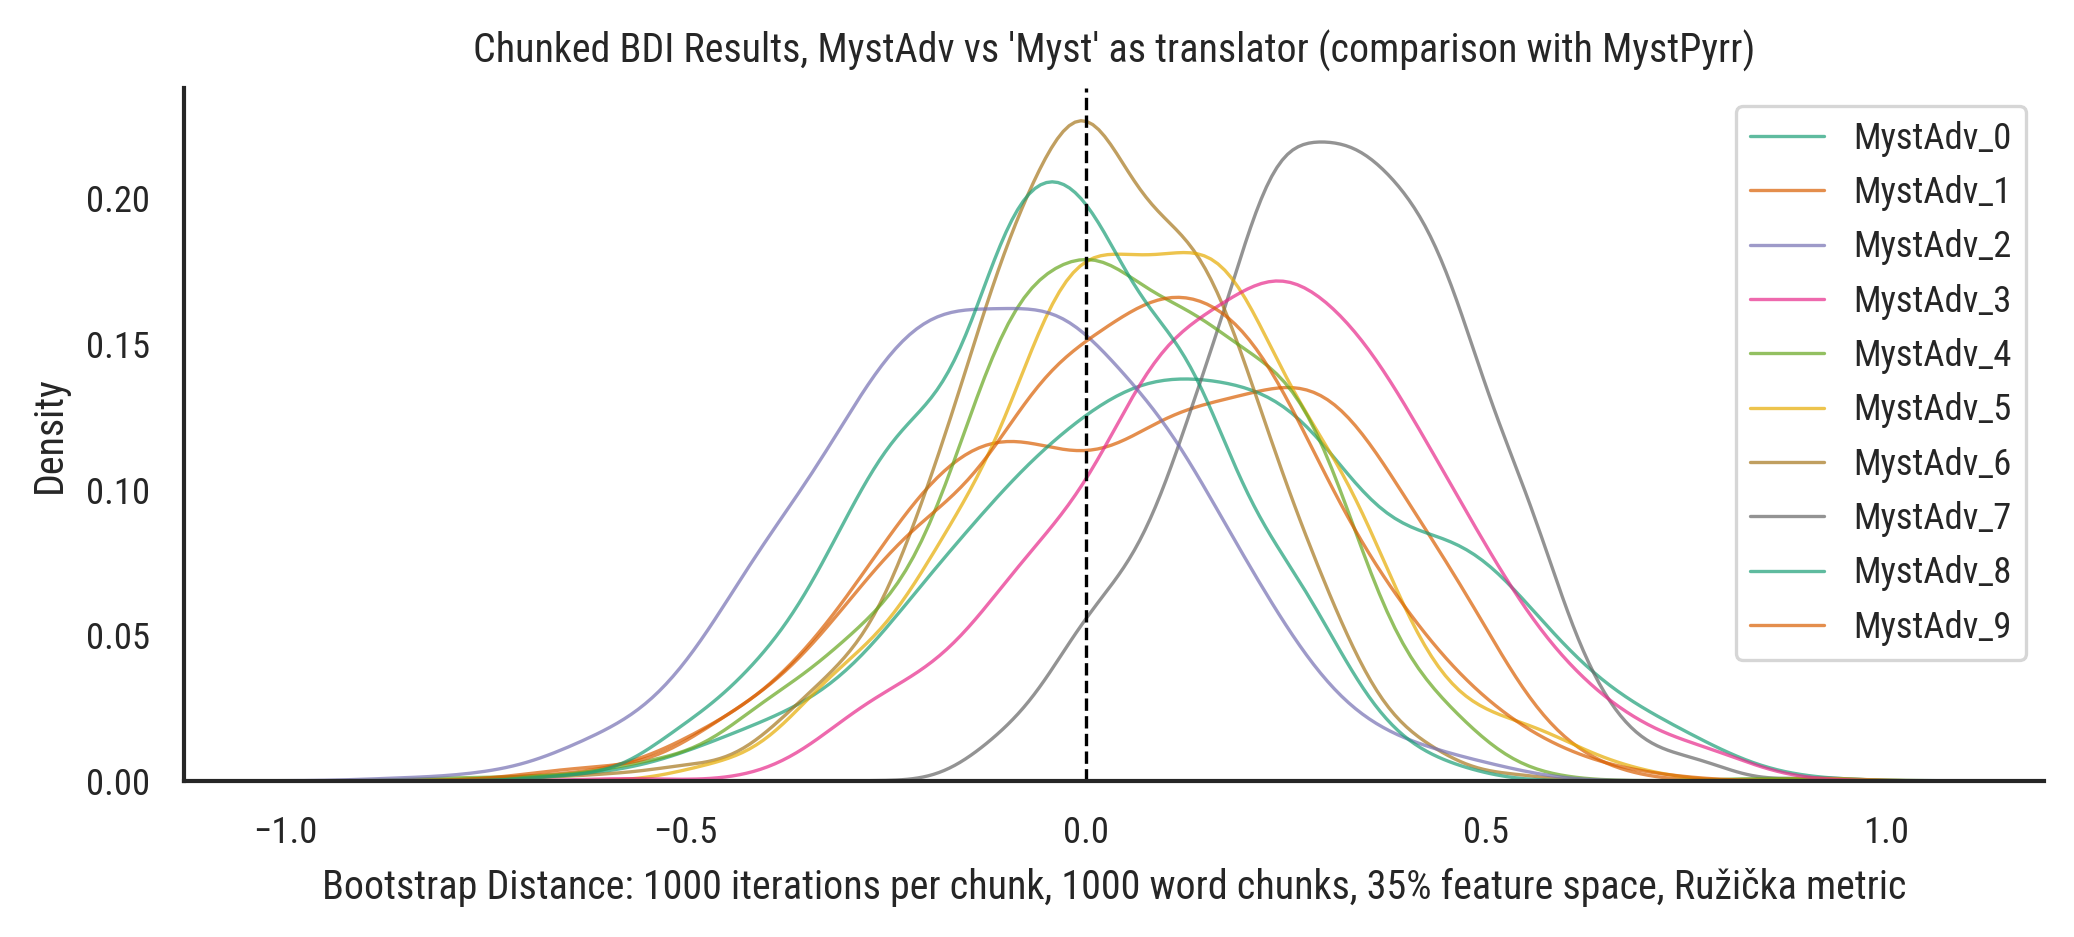

In [48]:
sns.set_theme(
    context="paper",
    font="Roboto Condensed",
    style="white",
    rc={"figure.figsize": (8, 3), "figure.dpi": 300},
)
ax = sns.kdeplot(adv_vs_myst, linewidth=0.8, alpha=0.7, palette="Dark2")
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.set(
    xlabel="Bootstrap Distance: 1000 iterations per chunk, 1000 word chunks, 35% feature space, Ružička metric",
    ylabel="Density",
    title="Chunked BDI Results, MystAdv vs 'Myst' as translator (comparison with MystPyrr)",
)
sns.despine()
plt.show()